# What makes predicting crime difficult?


Issue is that the distribution of crime does not change to much over time , i.e. ranking of the cells by crime rate does not seems to change that much over the long term. The models estimate the mean crime rate for a cell given the time, place and history of the cell. The model's crime rate estimate changes over time, but the ranking of cells seem to remain the same over the long term, especially whe working on spatial scales.

- Premise of thesis is that crime is influenced by past events and past neighbouring events.
- Crime follows a Poisson like process that is dependent on time, location and past events.
- Observations are sampled from poisson distribution given the time, location and past events.
- Possion distribution is described by the parameter $\lambda$.
- Difficult to estimate the $\lambda$ - hope to use neural networks for the task.
- Goal:
    - Total crime estimate in the city.
    - Crime distribution across the city for next time step.
- We evaluate the crime distribution by ranking the cells by the models estimated crime rate, $\lambda$.
- Rankings are monotonic so the scale of the estimated crime rates is not important.
    - Allows us to use classifiers and regressors.
- Seems that the neural network's rankings do not perform any better than baseline models which use periodic moving averages to estimate crime rates.
    - Hypothesise that crime is much more dependent on location and time of day/week/year than on past events. 
    - Even though past events might increase or decrease crime rates, the amount with which this happens is not enough to change ranking amongst cell.
- Therefore, we look into determining if a cell will have more or less crime than that of the baseline models estimated rates.
    - Issue with this is that almost all cells' estimates lie between 0 and 1 which puts  us in the same predicament - that we do not know the true crime rate on spatio-temporal point.
 
 
# How should we normalise our data, and why?

Scaling all features between 0 and 1 makes it easier for networks to compare various features and allows for quick training cycles. The network does not have to implicitly normalise the data. 

Concerns when normalising this data:
- Data is zero inflated poisson distributed
    - We do not have continuous values, we are working with counts. 
    - We have zeros than a poisson distributions with the same counts for values greater than 0.
    - We have outliers per cell, which scales down relavent values when min max scaling the data for model uses.
        - For instance, when most data in a cell lies between 0 and 5, but there is an outlier of 50, the majority of the data gets squished between 0 and 0.1.

Options:
- Cluster based
    - Normalise each cell relative to itself.
        - Network can distinguis between high and low crime rate times, regardless of location.
    - Normalise cells according to values of all cells.
        - Network can distinguish between high and low crime rate areas.
    - Divide data with mean of cell to easily determine if a  cell is above or below the expected rate for that time and location. 
- Clustering based
    - Normalise cells by scaling areas of cells by crime density to ensure cells have more similar crime rates, behaviours.

### Count normalisation by clustering

Crime is not uniformly distributed accross the city, where certain areas are sometimes orders of magnitudes more than in other areas. Neural networks often need a large amount of data to train. Areas with an extremely low crime rate can almost be seen as invalid for neural network training seeing as the is no informative information over time to determine any trends. This happens when the areas are divided into evenly sized grid cells. By using a clustering approach to divided the city into areas we achieve two things. 
1. Time signals are more comparable - there are no vast differences between the lowest and highest signals which should allow the model to find a general temporal behaviour much easier. 
2. Low frequency areas are grouped together into larger clusters with a higher frequency signal, removing none informative cells from the dataset. 

- Want to normalise our cells to make them more comparable so that training a single network on the various cells is easier.

We run clustering algorithms k-Means and Gaussian Mixture Models, increasing the number of clusters and comparing the uniformity score (how evenly the data is spread amongst clusters) for each number of clusters. The uniformity score is calculated by dividing the entropy of the current cluster distribution by that of the entropy of a discrete uniform distribution of the same size. This gives us a value between 0 and 1 with 1 being uniform and 0 the furthest possible from uniform. Uniform distribution's entropy is the maximum it can possibly be, but the actual value increases with the number of discrete values, therefore, we normalise our cluster distribution by the uniform distribution to be able to compare entropies of discrete distribution of various sizes.

In [26]:
# from sparse_discrete_table import SparseDiscreteTable, build_discrete_table
from ipywidgets import widgets
import pandas as pd
import numpy as np

import plotly.graph_objs as go
import plotly.express as px
from utils.data_processing import time_series_to_time_index
from pprint import pprint
from sparse_discrete_table import quick_mutual_info, quick_cond_mutual_info
from sparse_discrete_table import mutual_info_over_time, conditional_mutual_info_over_time
from utils.interactive import filter_frame, get_total_counts, new_bins, new_int_bins
from utils.interactive import get_mean_map, bin_data_frame, State
from matplotlib import rcParams

from utils.data_processing import encode_category
from pandas.api.types import CategoricalDtype

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

pd.set_option('mode.chained_assignment', None)

In [27]:
df = pd.read_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl")

crime_categories = [
        "THEFT",
        "BATTERY",
        "CRIMINAL DAMAGE",
        "NARCOTICS",
        "ASSAULT",
        "BURGLARY",
        "MOTOR VEHICLE THEFT",
        "ROBBERY",
]

category_mask = df['Primary Type'].isin(crime_categories)

# used to remove the anomalies
LAT_MIN, LAT_MAX = 41.641, 42.024 # 41.645, 42.022

LON_MIN, LON_MAX = -87.821, -87.525 # -87.934, -87.525

FREQ = '1H' # '1H' # '168H' # '24H' # 

freq_title = {
    "1H": "Hourly",
    "24H":"Daily",
    "168H":"Weekly",
}.get(FREQ, "Hourly")

DATE_MIN, DATE_MAX = {
    "1H":   ('2014-01-01', '2019-01-01'),
    "24H":  ('2001-01-01', '2019-01-01'),
    "168H": ('2001-01-01', '2019-01-01'),
}.get(FREQ, ('2014-01-01', '2019-01-01'),)


lon_mask = (df.Longitude > LON_MIN) & (df.Longitude < LON_MAX)
lat_mask = (df.Latitude > LAT_MIN) & (df.Latitude < LAT_MAX)
date_mask = (df.Date >= DATE_MIN) & (df.Date < DATE_MAX)


df = df[lon_mask & lat_mask & date_mask & category_mask]

df['t'] = time_series_to_time_index(t_series=df.Date, t_step=FREQ, floor=True)
df['c'] = encode_category(series=df['Primary Type'],categories=crime_categories)

In [28]:
# date selectors
date_range = pd.date_range(df.Date.min().ceil(FREQ), df.Date.max().ceil(FREQ), freq=FREQ)

In [29]:
from utils.interactive import get_ratio_xy
    
ratio_xy = get_ratio_xy(df)

In [30]:
from sklearn.mixture import GaussianMixture

In [31]:
import plotly.express as px
import plotly.graph_objects as go

In [32]:
def to_multi_dim_array(df, cols):
    """
    Only for values
    """
    assert (df[cols].min(0) == 0).all() == True
    shape = tuple(df[cols].max(0)+1)
    arr = np.zeros(shape)
    
    for row in df[cols].values:
        arr[row[0],row[1]] += 1
        
    return arr

In [33]:
import matplotlib.pyplot as plt

In [34]:
from sklearn.cluster import KMeans

In [35]:
sub = df[df.t < 100]

In [36]:
# use kl-diveregence on uniform dist and normalise the dist of the cell counts distributions to sum to one 

In [37]:
from sparse_discrete_table import entropy_from_array
from utils.plots import plot


def norm_array(arr):
    """
    arr should be 1d
    """
    assert np.min(arr) >= 0, "Min array value not >= 0"
    
    return arr/np.sum(arr)    

def scale_max_array(arr):
    """
    divide array by max value - al values are relative to max value
    """
    return arr/np.max(arr)    


def uniformity_score(arr):
    """
    arr: 1d array
    score is from 0 to 1 - where 0 is furthest from unifrom distribution and 1 is uniform distribution
    """
    n = len(arr)
    
    arr = norm_array(arr)
    arr_entropy = entropy_from_array(arr)
    
    max_entropy = entropy_from_array(norm_array(np.ones(n))) # highest entropy is most uniform
    
    normed_entropy = arr_entropy/max_entropy
    
    return normed_entropy

In [38]:
entropies = []
for s in np.linspace(0.00001,10,100):
    n = 300
    
    noise = np.random.rand(n)/s
    arr = noise + 1
    score = uniformity_score(arr)
    
    entropies.append(score)
    
plot(entropies=entropies, ylabel='Normalised Entropy', xlabel='Noise Sigma')

In [39]:
def normalized_std(series):
    """
    scale series between 0 and 1 and return the standard deviation of the rescaled 1d series
    
    series: 1d array
    returns: std of rescaled series
    """
    series = series - np.min(series)
    series = series/np.max(series)
    
    return np.std(series)

def uniform_mae(series):
    dist = series/np.sum(series)
    unif = np.ones(len(series))/len(series)
    return np.mean(np.abs(dist - unif))

In [40]:
# sub[['Latitude' , 'Longitude']] = sub[['Latitude' , 'Longitude']] - sub[['Latitude' , 'Longitude']].mean()
# sub[['Latitude' , 'Longitude']] = sub[['Latitude' , 'Longitude']] / sub[['Latitude' , 'Longitude']].std()

# sub['yy'] = sub['Latitude']*sub['Latitude']
# sub['xx'] = sub['Longitude']*sub['Longitude']
# sub['xy'] = sub['Longitude']*sub['Latitude']

# X = sub[['Latitude' , 'Longitude','xx','xy','yy', 'c']].values

X = sub[['Latitude' , 'Longitude']].values

best clusters are 90 with score of 0.9359977238478431


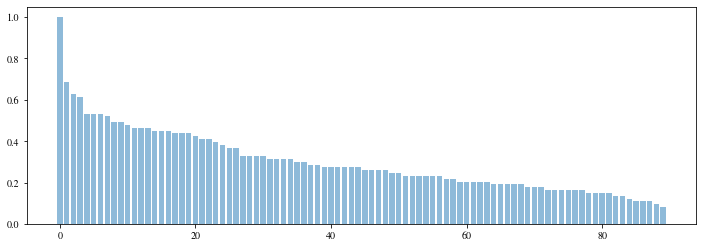

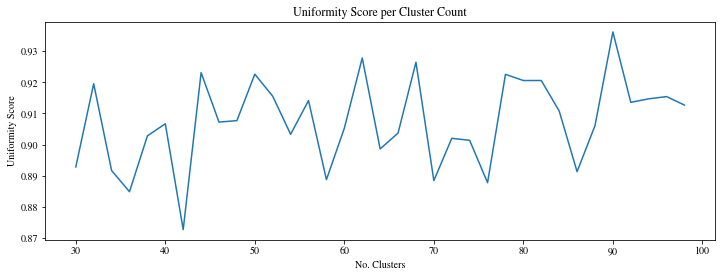

In [46]:
scores = []
cluster_options = list(range(30,100,2)) # [2,4,8,16,32,64]
for n_clusters in cluster_options:
    km = KMeans(n_clusters=n_clusters).fit(X)
    centers = km.cluster_centers_
    cluster = km.predict(X)
    sub['cluster'] = cluster
    cluster_counts = to_multi_dim_array(df=sub, cols=['t', 'cluster'])
    score = uniformity_score(cluster_counts.mean(0)**2)
    scores.append(score)
    
i = np.argmax(scores)
n_clusters = cluster_options[i]
print(f'best clusters are {n_clusters} with score of {scores[i]}')

km = KMeans(n_clusters=n_clusters).fit(sub[['Latitude' , 'Longitude']].values)
centers = km.cluster_centers_
cluster = km.predict(sub[['Latitude' , 'Longitude']].values)
sub['cluster'] = cluster
cluster_counts = to_multi_dim_array(df=sub, cols=['t', 'cluster'])
dist = norm_array(cluster_counts.mean(0))


dist = dist[np.argsort(dist)[::-1]]
dist = scale_max_array(dist)

plt.figure(figsize=(12,4))
plt.bar(np.arange(len(dist)), dist, alpha=.5)
plt.show()

plt.figure(figsize=(12,4))
plt.title('Uniformity Score per Cluster Count')
plt.ylabel('Uniformity Score')
plt.xlabel('No. Clusters')
plt.plot(cluster_options,scores)
plt.show()

fig = px.scatter(sub, y='Latitude' , x='Longitude', opacity=0.4, color='cluster', 
                 color_discrete_sequence=px.colors.qualitative.Light24)
fig.update_layout(height=800,width=600)
fig.show()

In [42]:
# entropy is maximized for uniform distribution thus we

best clusters are 32 with score of 0.9202043640469396


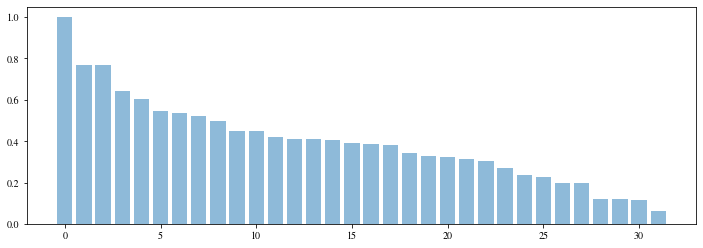

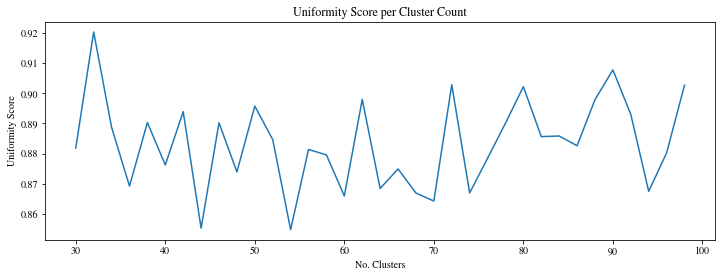

In [43]:
scores = []
cluster_options = list(range(30,100,2)) # [2,4,8,16,32,64]
for n_clusters in cluster_options:
    gm = GaussianMixture(n_components=n_clusters)
    gm.fit(X)
    cluster = gm.predict(X)
    centers = gm.means_
    sub['cluster'] = cluster
    cluster_counts = to_multi_dim_array(df=sub, cols=['t', 'cluster'])
    score = uniformity_score(cluster_counts.mean(0)**2)
    scores.append(score)
    
i = np.argmax(scores)
n_clusters = cluster_options[i]
print(f'best clusters are {n_clusters} with score of {scores[i]}')

gm = GaussianMixture(n_components=n_clusters)
gm.fit(sub[['Latitude' , 'Longitude']].values)
cluster = gm.predict(sub[['Latitude' , 'Longitude']].values)
centers = gm.means_
sub['cluster'] = cluster
cluster_counts = to_multi_dim_array(df=sub, cols=['t', 'cluster'])

dist = norm_array(cluster_counts.mean(0))

dist = dist[np.argsort(dist)[::-1]]
dist = scale_max_array(dist)

plt.figure(figsize=(12,4))
plt.bar(np.arange(len(dist)), dist, alpha=.5)
plt.show()

plt.figure(figsize=(12,4))
plt.title('Uniformity Score per Cluster Count')
plt.ylabel('Uniformity Score')
plt.xlabel('No. Clusters')
plt.plot(cluster_options,scores)
plt.show()


fig = px.scatter(sub, y='Latitude' , x='Longitude', opacity=0.4, color='cluster', 
                 color_discrete_sequence=px.colors.qualitative.Light24)
fig.update_layout(height=800,width=600)
fig.show()

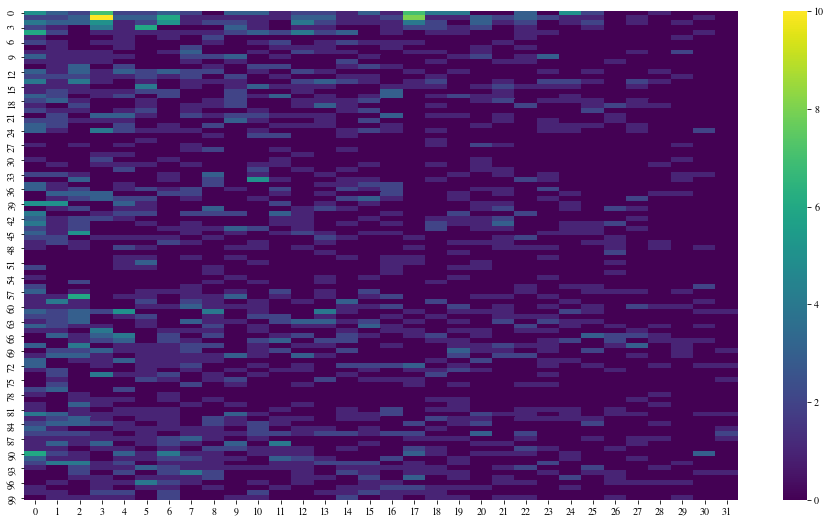

In [44]:
from utils.plots import im_sns
im_sns(cluster_counts[:,np.argsort(cluster_counts.sum(0))[::-1]])